# Installation

In [1]:
!pip install idx2numpy
!pip install mlflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7917 sha256=b88382d2d9f0eaba21574e0cc613a7db9fdc9c255de5235d305cab7d1145b91b
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 17.0 MB 14.3 MB/s 
     |████████████████████████████████| 77 kB 2.8 MB/s 
     |████████████████████████████████| 182 kB 16.2 MB/s 
     |████████████████████████████████| 79 kB 3.5 MB/s 
     |████████████████████████████████| 147 kB 23.2 MB/s 
     |████████████████████████████████| 209 kB 60.8 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 140 kB 80.9 MB

# Download Dataset

In [2]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

--2022-11-06 06:50:53--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  --.-KB/s    in 0.04s   

2022-11-06 06:50:53 (247 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2022-11-06 06:50:53--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 172.67.171.76, 104.21.29.36, 2606:4700:3036::ac43:ab4c, ...
Connecting to yann.lecun.com (yann.lecun.com)|172.67.171.76|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[==========

In [3]:
!gzip -d train-images-idx3-ubyte.gz
!gzip -d train-labels-idx1-ubyte.gz
!gzip -d t10k-images-idx3-ubyte.gz
!gzip -d t10k-labels-idx1-ubyte.gz

# Imports

In [4]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix

import os
import tensorflow as tf
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Conv2D,MaxPooling2D,Flatten
import pickle
import mlflow
import mlflow.sklearn

import warnings
warnings.filterwarnings('ignore')

#Load Data

- References :
> http://yann.lecun.com/exdb/mnist/ <br>
> https://stackoverflow.com/a/55504575


In [5]:
# http://yann.lecun.com/exdb/mnist/
# https://stackoverflow.com/a/55504575

train_X_filepath = "train-images-idx3-ubyte"
train_y_filepath = "train-labels-idx1-ubyte"
test_x_filepath = "t10k-images-idx3-ubyte"
test_y_filepath = "t10k-labels-idx1-ubyte"


train_x = idx2numpy.convert_from_file(train_X_filepath)
train_y = idx2numpy.convert_from_file(train_y_filepath)

test_x = idx2numpy.convert_from_file(test_x_filepath)
test_y = idx2numpy.convert_from_file(test_y_filepath)

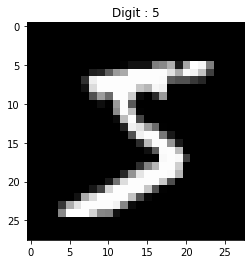

In [6]:
plt.title("Digit : {}".format(train_y[0]))
plt.imshow(train_x[0],cmap="gray")

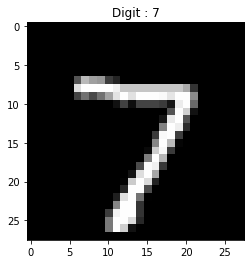

In [7]:
plt.title("Digit : {}".format(test_y[0]))
plt.imshow(test_x[0],cmap="gray")

# EDA and Preprocessing

In [8]:
print("train_x shape : ",train_x.shape)
print("test_x shape : ",test_x.shape)

train_x shape :  (60000, 28, 28)
test_x shape :  (10000, 28, 28)


- Each image contains shape of 28 x 28
- For training we have 60000 images and for testing we have 10000 images

In [9]:
unique, counts = np.unique(train_y, return_counts=True)

total_training_samples = train_y.shape[0]
print("Training data\n")
print("{} \t {} \t {}".format("Number","Counts", "% of data"))
for k,v in zip(unique,counts):
    print("{} \t {} \t {}".format(k,v,round(v/total_training_samples,4)*100))


Training data

Number 	 Counts 	 % of data
0 	 5923 	 9.87
1 	 6742 	 11.24
2 	 5958 	 9.93
3 	 6131 	 10.22
4 	 5842 	 9.74
5 	 5421 	 9.04
6 	 5918 	 9.86
7 	 6265 	 10.440000000000001
8 	 5851 	 9.75
9 	 5949 	 9.92


In [10]:
unique, counts = np.unique(test_y, return_counts=True)

total_training_samples = test_y.shape[0]
print("Testing data\n")
print("{} \t {} \t {}".format("Number","Counts", "% of data"))
for k,v in zip(unique,counts):
    print("{} \t {} \t {}".format(k,v,round(v/total_training_samples,4)*100))


Testing data

Number 	 Counts 	 % of data
0 	 980 	 9.8
1 	 1135 	 11.35
2 	 1032 	 10.32
3 	 1010 	 10.100000000000001
4 	 982 	 9.82
5 	 892 	 8.92
6 	 958 	 9.58
7 	 1028 	 10.280000000000001
8 	 974 	 9.74
9 	 1009 	 10.09


- - Here we can see that training and testing datasets are almost balanced for all classes

In [11]:
print("max pixel value : ",train_x[0].max())
print("min pixel value : ",train_x[0].min())

max pixel value :  255
min pixel value :  0


- Max value is 255 and min value is 0, let normalize all values between o and 1

In [12]:
# normalize all pixel values between 0 and 1
train_x =  train_x/255.
test_x =  test_x/255.

# Modeling

## Machine Learning

In [13]:
train_x_flatten = train_x.reshape(-1,28*28)
test_x_flatten = test_x.reshape(-1,28*28)

In [ ]:
def train_model_with_mlflow(experiment_name,
                            model,
                            grid_parameters,
                            train_x,
                            train_y,
                            test_x,
                            test_y,
                            scoring = 'accuracy',
                            cv=3):

    with mlflow.start_run():

        mlflow.set_experiment(experiment_name)

        random_search = RandomizedSearchCV(estimator = model ,  
                                param_distributions = grid_parameters,
                                scoring = scoring,
                                cv = cv,
                                verbose=0
                                )


        random_search.fit(train_x, train_y)

        print("best searched parameter : \n{}".format(random_search.best_params_))

        train_y_pred = random_search.best_estimator_.predict(train_x)
        test_y_pred = random_search.best_estimator_.predict(test_x)
    
        train_classification_report = classification_report(train_y,train_y_pred)
        train_classification_report_dict = classification_report(train_y,train_y_pred,output_dict=True)

        test_classification_report = classification_report(test_y,test_y_pred)
        test_classification_report_dict = classification_report(test_y,test_y_pred,output_dict=True)


        print("Train classification report : \n")
        print(train_classification_report)

        print("\nTest classification report : \n")
        print(test_classification_report)

        # save confusion matrix image
        cfm_plot = plot_confusion_matrix( random_search.best_estimator_,train_x,train_y)
        cfm_plot.figure_.savefig("confustion_matrix_train_data.png",dpi=300)

        mlflow.log_dict(train_classification_report_dict,"classification report_training.json")
        mlflow.log_dict(test_classification_report_dict,"classification report_testing.json")
        mlflow.log_dict(random_search.best_params_,"best_searched_parameters.json")
        mlflow.log_artifact("confustion_matrix_train_data.png")
        mlflow.sklearn.log_model(random_search.best_estimator_, experiment_name)



###Logistic Regression

2022/10/30 05:54:03 INFO mlflow.tracking.fluent: Experiment with name 'Logistic Regression MNIST' does not exist. Creating a new experiment.


best searched parameter : 
{'C': 0.1}
Train classification report : 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5923
           1       0.95      0.98      0.96      6742
           2       0.93      0.91      0.92      5958
           3       0.92      0.90      0.91      6131
           4       0.93      0.94      0.94      5842
           5       0.90      0.89      0.90      5421
           6       0.95      0.96      0.96      5918
           7       0.94      0.94      0.94      6265
           8       0.91      0.89      0.90      5851
           9       0.91      0.91      0.91      5949

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000


Test classification report : 

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0

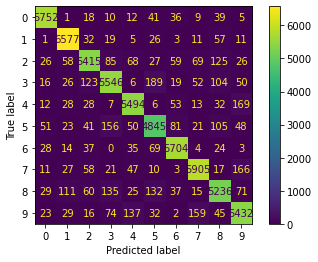

In [ ]:
LR = LogisticRegression()

lr_parameters = [{'penalty':['l1', 'l2']},
                    {'C':[0.01, 0.1, 1, 10, 100]},
                    {'solver':['liblinear']}]

experiment_name = "Logistic Regression MNIST"
lr_model = train_model_with_mlflow(experiment_name,
                                   LR,
                                   lr_parameters,
                                   train_x_flatten,
                                   train_y,
                                   test_x_flatten,
                                   test_y
                                   )

In [ ]:
filename = 'MNIST_Logistic_Regression.sav'
pickle.dump(lr_model, open(filename, 'wb'))
 

### Decision Tree

2022/10/30 06:09:00 INFO mlflow.tracking.fluent: Experiment with name 'Decision Tree Classifier MNIST' does not exist. Creating a new experiment.


best searched parameter : 
{'max_depth': 16, 'criterion': 'gini'}
Train classification report : 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5923
           1       0.99      1.00      0.99      6742
           2       0.99      0.99      0.99      5958
           3       0.99      0.98      0.99      6131
           4       0.98      0.99      0.99      5842
           5       0.99      0.99      0.99      5421
           6       1.00      0.99      0.99      5918
           7       0.98      0.99      0.99      6265
           8       0.99      0.98      0.99      5851
           9       0.97      0.98      0.98      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000


Test classification report : 

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       980
  

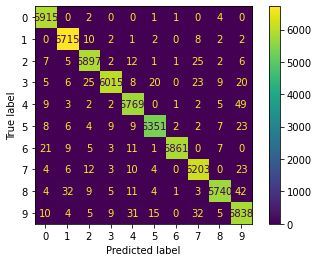

In [ ]:
dt = DecisionTreeClassifier()
experiment_name = "Decision Tree Classifier MNIST"
dt_parameters = {"criterion" : ['gini'],
                 "max_depth" : [2,4,6,8,10,12,14,16,18]
                  } 

dt_model = train_model_with_mlflow(experiment_name,
                                    dt,
                                    dt_parameters,
                                    train_x_flatten,
                                    train_y,
                                    test_x_flatten,
                                    test_y,
                                    )

In [ ]:
filename = 'MNIST_Decision_Tree.sav'
pickle.dump(dt_model, open(filename, 'wb'))

### Random Forest

2022/10/30 06:13:12 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest Classifier MNIST' does not exist. Creating a new experiment.


best searched parameter : 
{'n_estimators': 800, 'max_depth': 50}
Train classification report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       1.00      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000


Test classification report : 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
  

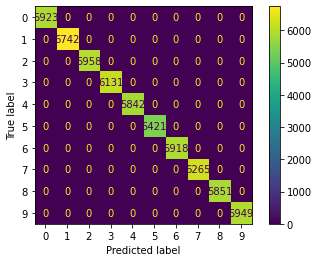

In [ ]:
rf = RandomForestClassifier()

experiment_name = "Random Forest Classifier MNIST"
rf_parameters={ 'max_depth': [10, 20, 30, 40, 50, None],
                'n_estimators': [50,200, 400, 600, 800]
               }

rf_model = train_model_with_mlflow(experiment_name,
                                    rf,
                                    rf_parameters,
                                    train_x_flatten,
                                    train_y,
                                    test_x_flatten,
                                    test_y,
                                    )

In [ ]:
filename = 'MNIST_Random_Forest.sav'
pickle.dump(rf_model, open(filename, 'wb'))

## Deep Learning

### ANN

In [14]:
model_save_folder = "ANN_MNIST"

mnist_ann_model = tf.keras.Sequential(
                    [
                        Dense(128, activation='relu', input_shape=(784,)),
                        Dense(24, activation='relu'),
                        Dropout(0.3),
                        BatchNormalization(),
                        Dense(24, activation='relu'),
                        Dropout(0.3),
                        BatchNormalization(),
                        Dense(10,activation='softmax')
                    ])

#Compiling the model
mnist_ann_model.compile(
              loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics = ['accuracy']
              )


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=3,
                                                            verbose=0,
                                                            restore_best_weights=True
                                                        )

history = mnist_ann_model.fit(train_x_flatten,
                            train_y,
                            validation_data=(test_x_flatten,test_y),
                            batch_size=128,
                            epochs=30,
                            callbacks=[early_stopping_callback])



Epoch 1/30
469/469 [==============================] - 3s 5ms/step - loss: 0.9106 - accuracy: 0.7201 - val_loss: 0.2453 - val_accuracy: 0.9395
Epoch 2/30
469/469 [==============================] - 2s 4ms/step - loss: 0.4393 - accuracy: 0.8732 - val_loss: 0.1487 - val_accuracy: 0.9588
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 0.3335 - accuracy: 0.9050 - val_loss: 0.1468 - val_accuracy: 0.9598
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 0.2832 - accuracy: 0.9207 - val_loss: 0.1268 - val_accuracy: 0.9643
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 0.2493 - accuracy: 0.9298 - val_loss: 0.1315 - val_accuracy: 0.9648
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 0.2315 - accuracy: 0.9355 - val_loss: 0.1058 - val_accuracy: 0.9729
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 0.2109 - accuracy: 0.9402 - val_loss: 0.1110 - val_accuracy: 0.9733
Epoch 

313/313 [==============================] - 0s 1ms/step
Train classification report : 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.99      0.99      0.99      5958
           3       0.98      0.98      0.98      6131
           4       0.99      0.99      0.99      5842
           5       0.99      0.98      0.98      5421
           6       0.99      0.99      0.99      5918
           7       1.00      0.97      0.99      6265
           8       0.97      0.99      0.98      5851
           9       0.97      0.98      0.98      5949

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000


Test classification report : 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1 

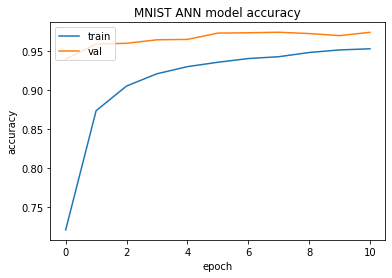

In [15]:
train_y_pred = mnist_ann_model.predict(train_x_flatten)
test_y_pred = mnist_ann_model.predict(test_x_flatten)

train_classification_report = classification_report(train_y,np.argmax(train_y_pred,axis=1))

test_classification_report = classification_report(test_y,np.argmax(test_y_pred,axis=1))

print("Train classification report : \n")
print(train_classification_report)

print("\nTest classification report : \n")
print(test_classification_report)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MNIST ANN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
# save model
mnist_ann_model.save(os.path.join(model_save_folder,"MNIST"))

In [17]:
!zip -r ANN_MNIST.zip ANN_MNIST

  adding: ANN_MNIST/ (stored 0%)
  adding: ANN_MNIST/MNIST/ (stored 0%)
  adding: ANN_MNIST/MNIST/assets/ (stored 0%)
  adding: ANN_MNIST/MNIST/keras_metadata.pb (deflated 91%)
  adding: ANN_MNIST/MNIST/saved_model.pb (deflated 89%)
  adding: ANN_MNIST/MNIST/variables/ (stored 0%)
  adding: ANN_MNIST/MNIST/variables/variables.index (deflated 68%)
  adding: ANN_MNIST/MNIST/variables/variables.data-00000-of-00001 (deflated 13%)


### CNN

In [ ]:
train_x_cnn = train_x.reshape((train_x.shape[0], 28, 28,1))
test_x_cnn = test_x.reshape((test_x.shape[0], 28, 28,1))

In [ ]:
model_save_folder = "CNN_MNIST"

mnist_cnn_model = tf.keras.Sequential(
                    [
                        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28,1)),
                        MaxPooling2D((2, 2)),
                        Flatten(),
                        BatchNormalization(),
                        Dense(100, activation='relu', kernel_initializer='he_uniform'),
                        Dropout(0.3),
                        BatchNormalization(),
                        Dense(10,activation='softmax')
                    ])

#Compiling the model
mnist_cnn_model.compile(
              loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics = ['accuracy']
              )


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=3,
                                                            verbose=0,
                                                            restore_best_weights=True
                                                        )

history = mnist_cnn_model.fit(train_x_cnn,
                            train_y,
                            validation_data=(test_x_cnn,test_y),
                            batch_size=128,
                            epochs=30,
                            callbacks=[early_stopping_callback])


Epoch 1/30
469/469 [==============================] - 35s 71ms/step - loss: 0.1913 - accuracy: 0.9445 - val_loss: 0.0838 - val_accuracy: 0.9773
Epoch 2/30
469/469 [==============================] - 34s 72ms/step - loss: 0.0707 - accuracy: 0.9789 - val_loss: 0.0585 - val_accuracy: 0.9811
Epoch 3/30
469/469 [==============================] - 38s 81ms/step - loss: 0.0488 - accuracy: 0.9855 - val_loss: 0.0491 - val_accuracy: 0.9837
Epoch 4/30
469/469 [==============================] - 33s 69ms/step - loss: 0.0356 - accuracy: 0.9891 - val_loss: 0.0481 - val_accuracy: 0.9854
Epoch 5/30
469/469 [==============================] - 34s 73ms/step - loss: 0.0273 - accuracy: 0.9920 - val_loss: 0.0388 - val_accuracy: 0.9885
Epoch 6/30
469/469 [==============================] - 37s 80ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0421 - val_accuracy: 0.9861
Epoch 7/30
469/469 [==============================] - 33s 70ms/step - loss: 0.0184 - accuracy: 0.9945 - val_loss: 0.0454 - val_accuracy:

313/313 [==============================] - 3s 9ms/step
Train classification report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5923
           1       1.00      1.00      1.00      6742
           2       1.00      1.00      1.00      5958
           3       1.00      1.00      1.00      6131
           4       1.00      1.00      1.00      5842
           5       1.00      1.00      1.00      5421
           6       1.00      1.00      1.00      5918
           7       1.00      1.00      1.00      6265
           8       1.00      1.00      1.00      5851
           9       1.00      1.00      1.00      5949

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000


Test classification report : 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1 

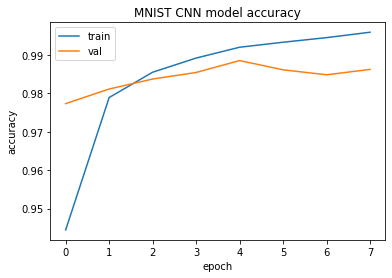

In [ ]:
train_y_pred = mnist_cnn_model.predict(train_x_cnn)
test_y_pred = mnist_cnn_model.predict(test_x_cnn)

train_classification_report = classification_report(train_y,np.argmax(train_y_pred,axis=1))

test_classification_report = classification_report(test_y,np.argmax(test_y_pred,axis=1))

print("Train classification report : \n")
print(train_classification_report)

print("\nTest classification report : \n")
print(test_classification_report)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('MNIST CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save model
# tf.saved_model.save(mnist_cnn_model,os.path.join(model_save_folder,"MNIST"))
mnist_cnn_model.save(model_save_folder)

In [ ]:
!zip -r CNN_MNIST.zip CNN_MNIST

updating: CNN_MNIST/ (stored 0%)
  adding: CNN_MNIST/saved_model.pb (deflated 89%)
  adding: CNN_MNIST/variables/ (stored 0%)
  adding: CNN_MNIST/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: CNN_MNIST/variables/variables.index (deflated 66%)
  adding: CNN_MNIST/keras_metadata.pb (deflated 90%)
  adding: CNN_MNIST/assets/ (stored 0%)


In [ ]:
import cv2

In [ ]:
def preprocess_for_recognize(img):
    img = cv2.resize(img,(28,28))
    cv2.imwrite("img.jpg",img)
    
    img = img / 255.
    
    # cv2.imwrite("img1.jpg",img*255)
    
    return img


In [ ]:
# https://towardsdatascience.com/non-maxima-suppression-139f7e00f0b5
def NMS(boxes, overlapThresh = 0.4):
    #return an empty list, if no boxes given
    if len(boxes) == 0:
        return []
    x1 = boxes[:, 0]  # x coordinate of the top-left corner
    y1 = boxes[:, 1]  # y coordinate of the top-left corner
    x2 = boxes[:, 2]  # x coordinate of the bottom-right corner
    y2 = boxes[:, 3]  # y coordinate of the bottom-right corner
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) # We have a least a box of one pixel, therefore the +1
    indices = np.arange(len(x1))
    for i,box in enumerate(boxes):
        temp_indices = indices[indices!=i]
        xx1 = np.maximum(box[0], boxes[temp_indices,0])
        yy1 = np.maximum(box[1], boxes[temp_indices,1])
        xx2 = np.minimum(box[2], boxes[temp_indices,2])
        yy2 = np.minimum(box[3], boxes[temp_indices,3])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / areas[temp_indices]
        if np.any(overlap) > overlapThresh:
            indices = indices[indices != i]
    selected_boxes = boxes[indices].astype(int)

    # add 10px margin on bounding box
    selected_boxes[:,0] = selected_boxes[:,0] - 10
    selected_boxes[:,1] = selected_boxes[:,1] - 10
    selected_boxes[:,2] = selected_boxes[:,2] + 10
    selected_boxes[:,3] = selected_boxes[:,3] + 10

    return selected_boxes


In [ ]:
def detect_digits(img_path):
    # https://stackoverflow.com/a/57623749
    mser = cv2.MSER_create()
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    regions, boundingBoxes = mser.detectRegions(gray)

    boundingBoxes = np.array(boundingBoxes)
    
    # convert x,y,w,h -> x1,y1,x2,y2
    boundingBoxes[:,2] = boundingBoxes[:,2] + boundingBoxes[:,0]
    boundingBoxes[:,3] = boundingBoxes[:,3] + boundingBoxes[:,1]
    
    return NMS(boundingBoxes)
    
 

    

In [ ]:
def recognize_digits(image_path):
    
    digits = []
    
    im_gray = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    thresh = 127
    im_bw = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]
    # im_bw = im_gray
    # print("im_bw : ",im_bw)
    im_bw = cv2.bitwise_not(im_bw)

    cv2.imwrite("Test.jpg",im_bw)
    
    selected_bounding_boxes = detect_digits(image_path)
    
    for bounding_box in selected_bounding_boxes:
        
        x1,y1, x2,y2 = bounding_box
        
        crop_image = im_bw[y1:y2,x1:x2]
        
        cv2.imwrite("crop_image.jpg",crop_image)
        cv2.rectangle(im_gray,(x1,y1),(x2,y2),(255,0,0),1)
        
        processed_img = preprocess_for_recognize(crop_image)
        cv2.imwrite("processed_img.jpg",processed_img)
        
        
        processed_img = np.expand_dims(processed_img,axis=-1)
        processed_img = np.expand_dims(processed_img,axis=0)
        
        print(processed_img.shape)
        
        
        prediction = mnist_cnn_model(processed_img)
        # print(prediction[0])
        digit = np.argmax(prediction[0])
        
        digits.append(digit)
        
        
    cv2.imwrite("test_bb.jpg",im_gray)
        
    return digits
    
    

In [ ]:
recognize_digits("/content/test_digit.jpg")

(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)


[6, 5, 2, 6, 9]

In [ ]:
# 